Feature count: 18
Supervised shape: (10862, 432) (10862,)
Train segment: (8689, 432) Test segment: (2173, 432)
[0]	train-rmse:141.92486	val-rmse:239.75029
[50]	train-rmse:28.26383	val-rmse:85.23688
[100]	train-rmse:14.51605	val-rmse:73.76701
[150]	train-rmse:10.82346	val-rmse:72.35215
[200]	train-rmse:8.26307	val-rmse:72.07835
[250]	train-rmse:6.44083	val-rmse:71.97750
[300]	train-rmse:5.14214	val-rmse:71.97567
[350]	train-rmse:4.09102	val-rmse:71.96411
[400]	train-rmse:3.29944	val-rmse:71.95756
[433]	train-rmse:2.88880	val-rmse:71.96371
RMSE: 76.7500
MAE:  52.2409
RMSLE: 0.3933
MAPE: 35.35%
R2:   0.8757


C:\Users\joobzm\Desktop\TDK\ACPI\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


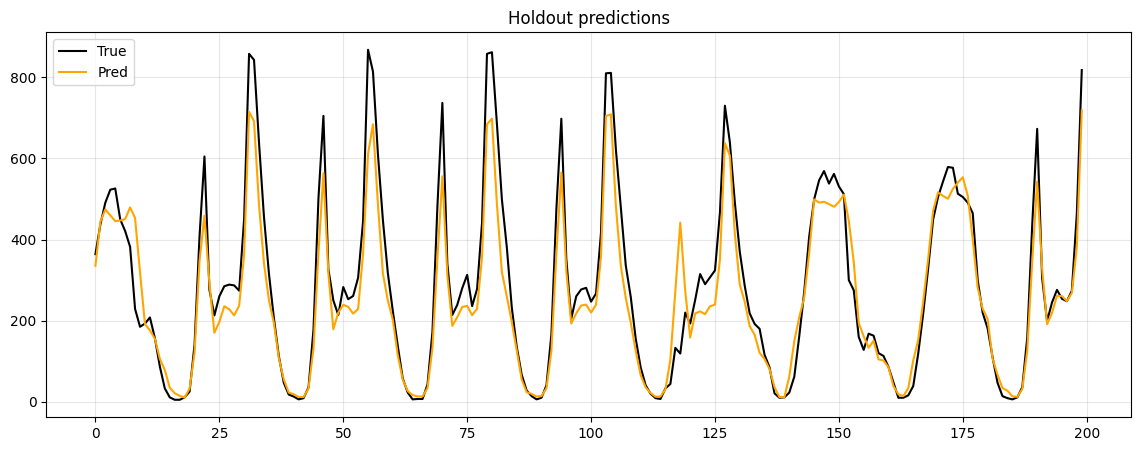

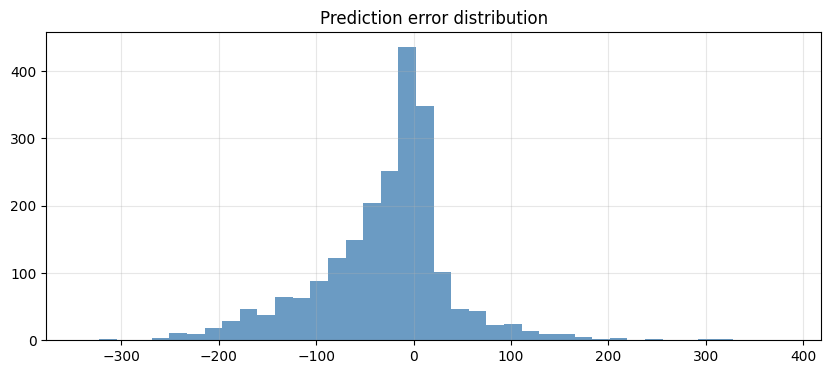

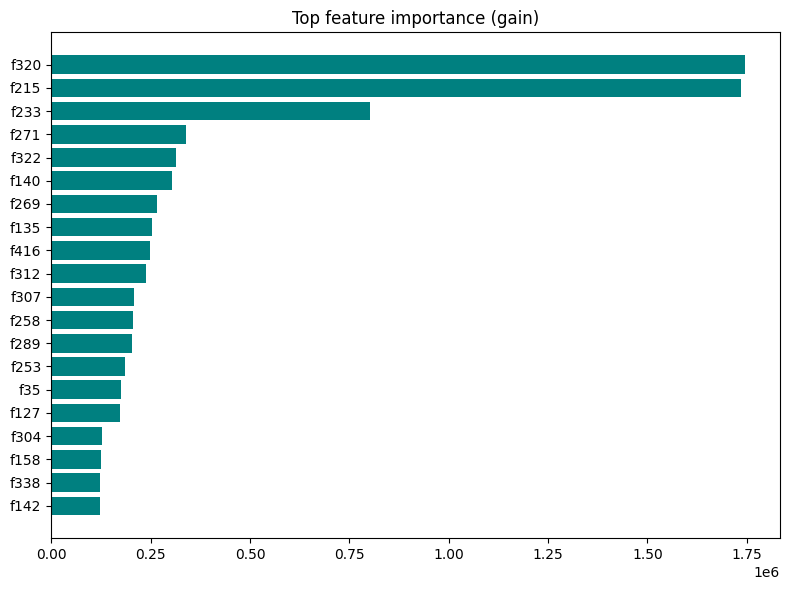

Done.


In [9]:
from sklearn.metrics import mean_squared_log_error
from typing import Optional, Callable

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

DATA_TRAIN_PATH = "data/train.csv"
DATA_TEST_PATH = "data/test.csv"
target_col = "count"

def read_data(path):
    df = pd.read_csv(path, parse_dates=["datetime"])

    season = pd.get_dummies(df['season'], prefix='season')
    df = pd.concat([df, season], axis=1)

    weather = pd.get_dummies(df['weather'], prefix='weather')
    df = pd.concat([df, weather], axis=1)

    df.drop(['season', 'weather'], axis=1, inplace=True)

    dt_index = pd.DatetimeIndex(df.datetime)
    df['hour'] = dt_index.hour
    df['day'] = dt_index.dayofweek
    df['month'] = dt_index.month
    df['year'] = dt_index.year.map({2011: 0, 2012: 1})

    df.drop('datetime', axis=1, inplace=True)

    # Drop train-only columns if present
    drop_cols = [c for c in ['casual', 'registered'] if c in df.columns]
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)

    return df

train_df = read_data(DATA_TRAIN_PATH)
test_df = read_data(DATA_TEST_PATH)

feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]
print(f"Feature count: {len(feature_cols)}")

scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)


def build_lag_supervised(features, target, context_length):
    X_list, y_list = [], []
    for i in range(len(target) - context_length):
        X_window = features[i:i + context_length].reshape(-1)
        y_val = target[i + context_length]
        X_list.append(X_window)
        y_list.append(y_val)
    return np.vstack(X_list).astype(np.float32), np.array(y_list, dtype=np.float32)


context_length = 24
X_all, y_all = build_lag_supervised(train_features, train_target, context_length)
print("Supervised shape:", X_all.shape, y_all.shape)

# Train / holdout split (time-ordered)
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_model, X_test_hold = X_all[:n_train], X_all[n_train:]
y_model, y_test_hold = y_all[:n_train], y_all[n_train:]
print("Train segment:", X_model.shape, "Test segment:", X_test_hold.shape)

# Train / validation for early stopping
X_tr, X_val, y_tr, y_val = train_test_split(X_model, y_model, test_size=0.15, shuffle=False)

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 8,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "gamma": 0.0,
    "min_child_weight": 1
}

evals = [(dtrain, "train"), (dval, "val")]
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# Evaluate on holdout
y_pred = bst.predict(xgb.DMatrix(X_test_hold))

rmse = mean_squared_error(y_test_hold, y_pred, squared=False)
mae = mean_absolute_error(y_test_hold, y_pred)
with np.errstate(divide='ignore', invalid='ignore'):
    mape = np.mean(np.abs((y_test_hold - y_pred) / np.clip(np.abs(y_test_hold), 1e-6, None))) * 100
r2 = r2_score(y_test_hold, y_pred)

rmsle = np.sqrt(mean_squared_log_error(y_test_hold, y_pred))

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSLE: {rmsle:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2:   {r2:.4f}")

# Plot predictions vs actual
n_plot = min(200, len(y_test_hold))
idx = np.arange(n_plot)
plt.figure(figsize=(14, 5))
plt.plot(idx, y_test_hold[:n_plot], label="True", color="black")
plt.plot(idx, y_pred[:n_plot], label="Pred", color="orange")
plt.title("Holdout predictions")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Error distribution
errors = y_pred - y_test_hold
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=40, color="steelblue", alpha=0.8)
plt.title("Prediction error distribution")
plt.grid(alpha=0.3)
plt.show()

# Feature importance (by gain)
importance = bst.get_score(importance_type="gain")
if importance:
    imp_items = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    labels, vals = zip(*imp_items)
    plt.figure(figsize=(8, 6))
    plt.barh(labels[::-1], vals[::-1], color="teal")
    plt.title("Top feature importance (gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance available.")

print("Done.")


In [12]:
# ACPI Implementation
from acpi import ACPI
from acpi.utils import compute_coverage

# Split holdout set into calibration and test sets
cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_cal, X_test_acpi = X_test_hold[:n_cal], X_test_hold[n_cal:]
y_cal, y_test_acpi = y_test_hold[:n_cal], y_test_hold[n_cal:]

print(f"Calibration set size: {len(X_cal)}")
print(f"ACPI Test set size: {len(X_test_acpi)}")


class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)


# Wrap the trained XGBoost model
xgb_wrapper = XGBoostACPIWrapper(bst)

Calibration set size: 1086
ACPI Test set size: 1087


In [18]:
# Initialize and fit ACPI
alpha = 0.1
acpi_model = ACPI(
    model_cali=xgb_wrapper,
    n_estimators=200,
    max_depth=25,
    min_node_size=15
)

print("\nFitting ACPI model...")
acpi_model.fit(X_cal, y_cal)
acpi_model.fit_calibration(X_cal, y_cal, quantile=(1 - alpha), only_qrf=True)
print("ACPI fitting complete.")

# Generate prediction intervals
y_lower, y_upper = acpi_model.predict_pi(X_test_acpi, method="qrf")

# Evaluate coverage
coverage = compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"\nACPI Coverage: {coverage:.4f} (Target: {1-alpha:.4f})")

# Get point predictions for comparison
y_pred_acpi = xgb_wrapper.predict(X_test_acpi)


Fitting ACPI model...


100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


ACPI fitting complete.

ACPI Coverage: 0.9430 (Target: 0.9000)


# Plot ACPI Results


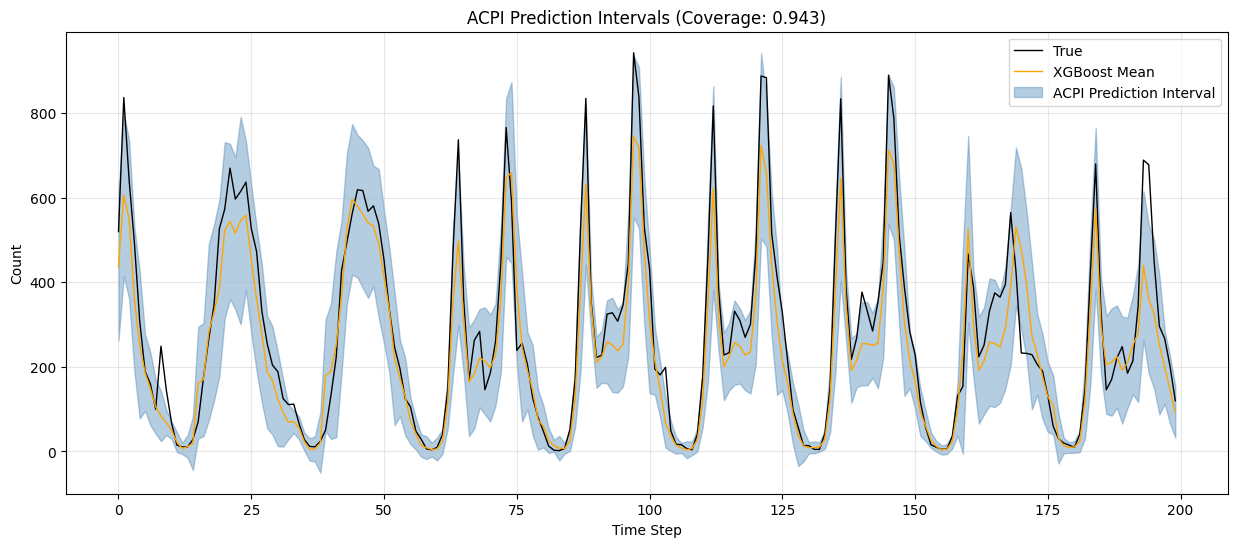

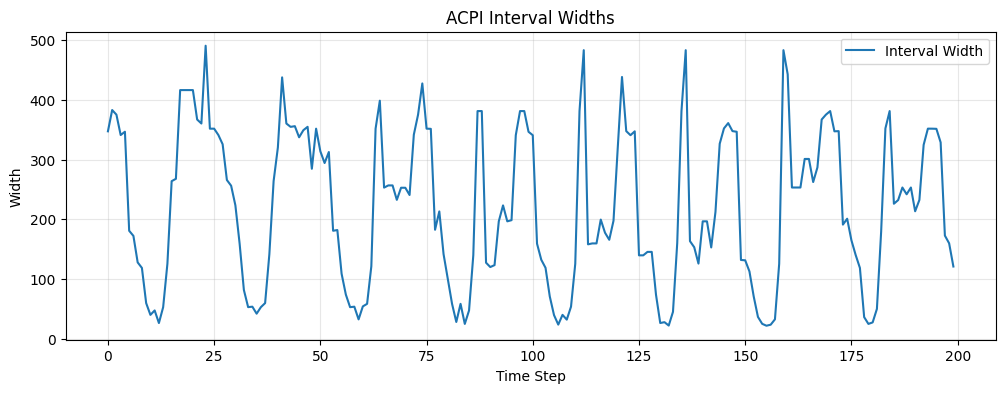

Below: 8 (0.74%)
Above: 54 (4.97%)
Within: 1025 (94.30%)


In [19]:
# Plot predictions with intervals
n_plot_acpi = min(200, len(y_test_acpi))
idx_acpi = np.arange(n_plot_acpi)

plt.figure(figsize=(15, 6))
plt.plot(idx_acpi, y_test_acpi[:n_plot_acpi], label="True", color="black", linewidth=1)
plt.plot(idx_acpi, y_pred_acpi[:n_plot_acpi], label="XGBoost Mean", color="orange", linewidth=1)
plt.fill_between(idx_acpi, y_lower[:n_plot_acpi], y_upper[:n_plot_acpi], color="steelblue", alpha=0.4, label="ACPI Prediction Interval")
plt.title(f"ACPI Prediction Intervals (Coverage: {coverage:.3f})")
plt.xlabel("Time Step")
plt.ylabel("Count")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot interval widths
interval_widths = y_upper - y_lower
plt.figure(figsize=(12, 4))
plt.plot(interval_widths[:n_plot_acpi], label="Interval Width")
plt.title("ACPI Interval Widths")
plt.xlabel("Time Step")
plt.ylabel("Width")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Coverage statistics
n_below = (y_test_acpi < y_lower).sum()
n_above = (y_test_acpi > y_upper).sum()
n_within = len(y_test_acpi) - n_below - n_above
total = len(y_test_acpi)

print(f"Below: {n_below} ({n_below/total:.2%})")
print(f"Above: {n_above} ({n_above/total:.2%})")
print(f"Within: {n_within} ({n_within/total:.2%})")

In [21]:
from itertools import product
import pandas as pd
from tqdm import tqdm

def acpi_grid_search(X_cal, y_cal, X_test, y_test, xgb_wrapper, alpha=0.1,
                     param_grid=None):


    target_coverage = 1 - alpha
    results = []
    param_combinations = list(product(*param_grid.values()))
    total_combinations = len(param_combinations)
    print(f"Total parameter combinations to evaluate: {total_combinations}")

    for params in tqdm(param_combinations, desc="Grid Search"):
        param_dict = dict(zip(param_grid.keys(), params))

        acpi_model = ACPI(
            model_cali=xgb_wrapper,
            n_estimators=param_dict['n_estimators'],
            max_depth=param_dict['max_depth'],
            min_node_size=param_dict['min_node_size']
        )

        acpi_model.fit(X_cal, y_cal)
        acpi_model.fit_calibration(X_cal, y_cal, quantile=target_coverage, only_qrf=True)

        y_lower, y_upper = acpi_model.predict_pi(X_test, method="qrf")
        coverage = compute_coverage(y_test, y_lower, y_upper)

        results.append({
            **param_dict,
            'coverage': coverage,
            'coverage_diff': abs(coverage - target_coverage)
        })

    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='coverage_diff')
    return results_df
# Perform grid search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [15, 20, 25],
    'min_node_size': [10, 15, 20]
}

grid_results = acpi_grid_search(X_cal, y_cal, X_test_acpi, y_test_acpi, xgb_wrapper, alpha=0.1, param_grid=param_grid)
print("\nGrid Search Results:")
print(grid_results.head(10))



Total parameter combinations to evaluate: 27


Grid Search: 100%|██████████| 27/27 [1:02:56<00:00, 139.89s/it]


Grid Search Results:
    n_estimators  max_depth  min_node_size  coverage  coverage_diff
4            100         20             15  0.914443       0.014443
26           200         25             20  0.923643       0.023643
10           150         15             15  0.925483       0.025483
11           150         15             20  0.927323       0.027323
3            100         20             10  0.929163       0.029163
1            100         15             15  0.929163       0.029163
24           200         25             10  0.929163       0.029163
15           150         25             10  0.932843       0.032843
5            100         20             20  0.932843       0.032843
13           150         20             15  0.933763       0.033763


In [22]:
# save the grid search results to a CSV file
grid_results.to_csv("acpi_xgboost_grid_search_results.csv", index=False)

In [23]:
#print the best parameters
best_params = grid_results.iloc[0]
print("\nBest Parameters:")
print(best_params)


Best Parameters:
n_estimators     100.000000
max_depth         20.000000
min_node_size     15.000000
coverage           0.914443
coverage_diff      0.014443
Name: 4, dtype: float64


In [25]:
# train and save the best ACPI model
best_acpi_model = ACPI(
    model_cali=xgb_wrapper,
    n_estimators= int(best_params['n_estimators']),
    max_depth= int(best_params['max_depth']),
    min_node_size= int(best_params['min_node_size'])
)
best_acpi_model.fit(X_cal, y_cal)
best_acpi_model.fit_calibration(X_cal, y_cal, quantile=0.9
, only_qrf=True)
import joblib
joblib.dump(best_acpi_model, "CF_Generators/models/acpi_xgboost_model_1.pkl")


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


['best_acpi_xgboost_model.pkl']